In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# to split the data into random training and testing subsets.
from sklearn.model_selection import train_test_split

# to calculate the confusion matrix
from sklearn.metrics import confusion_matrix

# to reduce the learning rate when a metric has stopped improving.
from keras.callbacks import ReduceLROnPlateau

# to be able to import use the pre-train VGG19 model
from tensorflow.keras.applications import VGG19

# to convert class vector (y) (integers) to binary class matrix.
from tensorflow.keras.utils import to_categorical

# to generate altered images
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# to initialize the desente gradient method
from tensorflow.keras.optimizers import SGD, Adam

from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout

In [4]:
if os.path.isdir("./saved_model"):
    try:
        strr= input('delete saved model? Y/N')
        if strr == 'Y' or strr == 'y':
            !rm -rf "./saved_model"
            print("deleted model")
        else:
            print('the old model will be used')
    except:

        pass

In [5]:
"""
    The functions used to retrieve the dataset
"""

# ------------------------------------------------- ---------------------
def in_colab():
    """
        detect if notebook is running on colab

    Returns:
        boolean: true or false
    """
    try:
        import google.colab

        IN_COLAB = True
    except:
        IN_COLAB = False
    return IN_COLAB


# ------------------------------------------------- ----------------------
def in_kaggle():
    """
        detect if notebook is running on Kaggle

    Returns:
        boolean: true or false
    """
    import os

    return os.path.isdir("../input") and os.path.isdir("/kaggle/working")


# ------------------------------------------------- ------------------------
def download_dataset(url, dataset_name):
    """
        download the dataset dfrom a given link

    args:
        URL (str): the link to download the dataset
        dataset_name (str): the name of the dataset (kvasir-dataset)

    Returns:
        str: the path to the dataset download
    """ """"""
    import tensorflow as tf
    import os

    path_to_zip = tf.keras.utils.get_file(
        f"{dataset_name}.zip", origin=URL, extract=True
    )
    path = os.path.join(os.path.dirname(path_to_zip), dataset_name)
    return path

In [6]:
import requests, zipfile, io, os

url = "https://datasets.simula.no/downloads/kvasir/kvasir-dataset.zip"
print("Downloading...")

response = requests.get(url, verify=False)
os.makedirs("dataset_dir", exist_ok=True)

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall("dataset_dir")

print("Downloaded and extracted into dataset_dir/")



Downloading...


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datasets.simula.no'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and extracted into dataset_dir/


In [9]:
import numpy as np
import pandas as pd
import os

dataset_dir = "dataset_dir/kvasir-dataset"

def get_dataCategories(dataset_dir):
    """
        get the categories (class) of the dataset from the path of the dataset
        in question.

    args:
        dataset_dir (str): dataset path

    Returns:
        list: list of categories
        list: list of number of files by categories
    """
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories. sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])


categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"category": categories, "number of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  8


,category,number of files
0,dyed-lifted-polyps,500
1,dyed-resection-margins,500
2,esophagitis,500
3,normal-cecum,500
4,normal-pylorus,500
5,normal-z-line,500
6,polyps,500
7,ulcerative-colitis,500


In [11]:
def create_dataset(datadir, categories, img_wid, img_high):
    """
        reads the images from the dataset and resizes them using the dimensions
        (img_wid x img_high ) to create all X features and y labels

    args:
        datadir (str): dataset path
        categories (str): the different classes of the dataset
        img_wid(int): custom width
        img_high(int): custom height

    Returns:
        X(numpy): the set of features (i.e: includes all the images read)
        y(numpy): the set of labels (i.e: includes the categories of each image of X)
    """

    x, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories. index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                x.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                pass

    y = np.array(y)
    X = np.array(x).reshape(y.shape[0], img_wid, img_wid, 3)
    return X,y




img_wid, img_high = 100, 100
X, y = create_dataset(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (4000, 100, 100, 3)
y: (4000,)


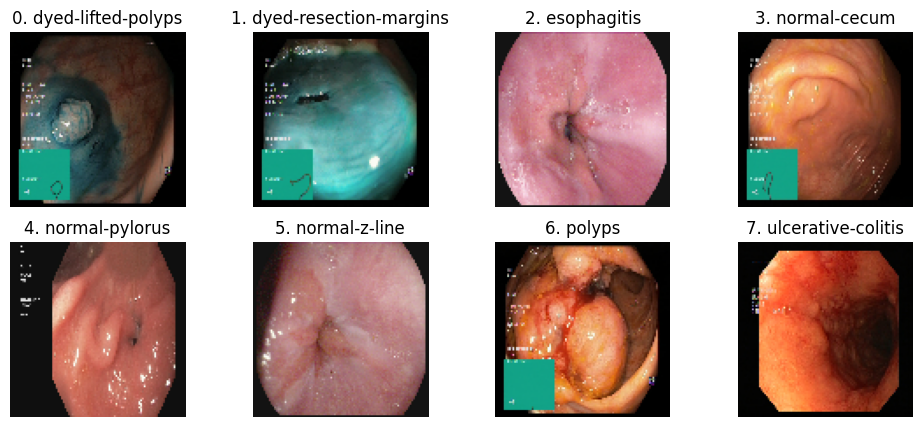

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500

    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()


In [13]:
# en convertie y en format scaler
Y = np.reshape(y, (len(y), 1))

# split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=42)
print(f"X_train: {X_train.shape}")
print(f"t_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


X_train: (3200, 100, 100, 3)
t_train: (3200, 1)
X_test: (800, 100, 100, 3)
y_test: (800, 1)


In [14]:
# defining training and test sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
x_test = X_test

# Dimension of the dataset
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")


x_train:(2240, 100, 100, 3),  y_train:(2240, 1)
x_train:(960, 100, 100, 3),  y_train:(960, 1)
x_train:(800, 100, 100, 3),  y_train:(800, 1)


In [15]:
# One Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Verifying the dimension after one hot encoding
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2240, 100, 100, 3),  y_train:(2240, 8)
x_train:(960, 100, 100, 3),  y_train:(960, 8)
x_train:(800, 100, 100, 3),  y_train:(800, 8)


In [16]:
# Image Data Augmentation
train_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

val_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

test_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)


In [17]:
# if it has already been created and saved --> read the model
if os.path.isfile("./saved_model/vgg19_model.h5"):
    #loadmodel
    base_model = load_model("./saved_model/vgg19_model.h5")

# if it has not already been created --> create the model and save it
else:
    base_model = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(100, 100, 3),
        classes=y_train.shape[1],
    )
    # save model
    base_model.save("./saved_model/vgg19_model.h5")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model = Sequential()
model.add(base_model)
model.add(Flatten())

In [19]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 3, 3, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# activation_functions = ["relu"]
# learning_rates = [0.0001, 0.00001]

# # Loop through activation functions and learning rates
# for learn_rate in learning_rates:
#     print(f"Training with activation function: {activation_functions[0]} and learning rate: {learn_rate}")
#     model.add(Dense(1024, activation="relu", input_dim=512))
#     model.add(Dense(512, activation="relu"))
#     model.add(Dense(256, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(Dense(128, activation="relu"))
#     # model.add(Dropout(.2))
#     model.add(Dense(y_train.shape[1], activation=("softmax")))
#     model.summary()
#     # initialize the number of training samples
#     batch_size = 100

#     # initialize the number of iterations
#     epochs = 100

#     # learning rate
#     # learn_rate = 0.0000

#     # initialize gradient descent
#     sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

#     # initialization of the Adam gradient descent
#     # adam = Adam( learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#     # compile the model
#     model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])
#     lrr = ReduceLROnPlateau(monitor="val_acc", factor=0.01, patience=3, min_lr=1e-5)


# # if the model has not already been trained --> train the model
#     history = model.fit(
#       # train_generator.flow(x_train, y_train, batch_size= batch_size),
#     x_train,
#     y_train,
#     epochs=epochs,
#     steps_per_epoch=x_train.shape[0] // batch_size,
#     validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
#     validation_steps=250,
#     callbacks=[lrr],
#     verbose=1,
#   )

#     # save model
#     np.save("./saved_model/model_history_{activation_functions[0]}_{learn_rate}.npy", history.history)
#     model.save("./saved_model/model_{activation_functions[0]}_{learn_rate}.h5")

#     score = model.evaluate(x_test, y_test, verbose=0)
#     print("Test loss:", round(score[0], 3))
#     print("Test accuracy:", round(score[1], 3))
#     print(score)

In [21]:
# activation_functions = ["relu"]
# learning_rates = [0.001, 0.0001]

# # Plotting
# plt.figure(figsize=(12, 8))

# # Loop through activation functions and learning rates
# for activation_function in activation_functions:
#     for learn_rate in learning_rates:
#         # Load model history
#         history = np.load(f"./saved_model/model_history_{activation_functions[0]}_{learn_rate}.npy", allow_pickle=True).item()

#         # Plot training and validation accuracy
#         plt.plot(history['accuracy'], label=f'Train Acc ({activation_functions[0]}, lr={learn_rate})', linestyle='--')
#         plt.plot(history['val_accuracy'], label=f'Val Acc ({activation_functions[0]}, lr={learn_rate})')

#         # Plot training and validation loss
#         plt.plot(history['loss'], label=f'Train Loss ({activation_functions[0]}, lr={learn_rate})', linestyle='--')
#         plt.plot(history['val_loss'], label=f'Val Loss ({activation_functions[0]}, lr={learn_rate})')

# plt.title('Training and Validation Metrics Comparison')
# plt.xlabel('Epochs')
# plt.ylabel('Metrics')
# plt.legend()
# plt.grid(True)
# plt.show()

In [22]:
model.add(Dense(1024, activation=("relu"), input_dim=512))
model.add(Dense(512, activation=("relu")))
model.add(Dense(256, activation=("relu")))
model.add(Dropout(0.3))
model.add(Dense(128, activation=("relu")))
# model.add(Dropout(.2))
model.add(Dense(y_train.shape[1], activation=("softmax")))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 3, 3, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,434,056 (97.02 MB)

 Trainable params: 25,434,056 (97.02 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
""" Initializing the hyperparameters """

# initialize the number of training samples
batch_size = 100

# initialize the number of iterations
epochs = 100

# learning rate
learn_rate = 0.00001

# initialize gradient descent
sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

# initialization of the Adam gradient descent
# adam = Adam( learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# compile the model
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

In [25]:
# Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor="val_acc", factor=0.01, patience=3, min_lr=1e-5)

In [26]:
# if model has already been trained and saved ---> read model
if os.path.isfile("./saved_model/model.h5"):

    # read the model
    model = load_model("./saved_model/model.h5")

    # if model history was saved --> read history
    if os.path.isfile("./saved_model/model_history.npy"):

        # read history
        history = np.load("./saved_model/model_history.npy", allow_pickle="TRUE").item()
    else:
        history = None

# if the model has not already been trained --> train the model
else:
    history = model.fit(
        # train_generator.flow(x_train, y_train, batch_size= batch_size),
        x_train,
        y_train,
        epochs=epochs,
        steps_per_epoch=x_train.shape[0] // batch_size,
        validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
        validation_steps=250,
        callbacks=[lrr],
        verbose=1,
    )
    history = history. history

    # save model
    np.save("./saved_model/model_history.npy", history)
    model.save("./saved_model/model.h5")

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1005 - loss: 9.3470   

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.1015 - loss: 9.2070 - val_accuracy: 0.1760 - val_loss: 2.3587 - learning_rate: 1.0000e-05
Epoch 2/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 561ms/step - accuracy: 0.1907 - loss: 2.3056 - val_accuracy: 0.2260 - val_loss: 2.0504 - learning_rate: 1.0000e-05
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 573ms/step - accuracy: 0.2676 - loss: 1.9893 - val_accuracy: 0.2594 - val_loss: 1.9478 - learning_rate: 1.0000e-05
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 572ms/step - accuracy: 0.3019 - loss: 1.8849 - val_accuracy: 0.2740 - val_loss: 1.9422 - learning_rate: 1.0000e-05
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 562ms/step - accuracy: 0.3517 - loss: 1.7696 - val_accuracy: 0.3167 - val_loss: 1.8661 - learning_rate: 1.0000e-05
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 562ms/step - accuracy: 0.4004 - loss: 1.6489 - val_accuracy: 0.3281 - val_loss: 1.7743 - learning_rate: 1.0000e-05
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - accuracy: 0.4298 - loss: 1.5859 - val_accuracy: 0.3771 - val_loss: 1.7305 - learning_rate: 1.0000e-05
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 564ms/step - accuracy

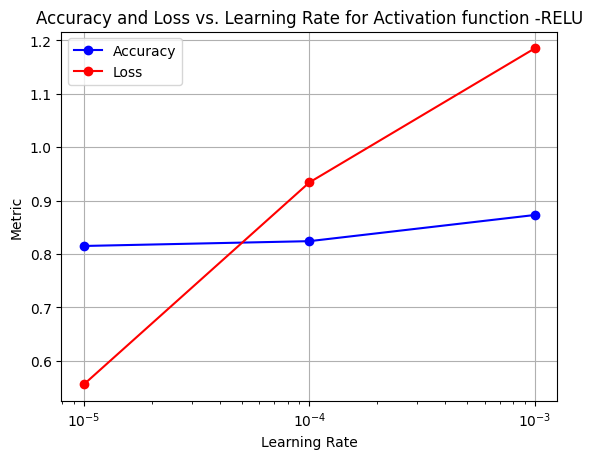

In [27]:
lr = [0.001,0.0001,0.00001]
accuracy = [0.873,0.824,0.815]
loss = [1.185,0.934,0.556]
plt.plot(lr, accuracy, marker='o', color='blue', label='Accuracy')

# Loss plot
plt.plot(lr, loss, marker='o', color='red', label='Loss')

# Set labels and title
plt.title('Accuracy and Loss vs. Learning Rate for Activation function -RELU')
plt.xlabel('Learning Rate')
plt.ylabel('Metric')
plt.xscale('log')  # Set x-axis to log scale for better visualization of learning rates
plt.grid(True)
plt.legend()

# Show plot
plt.show()

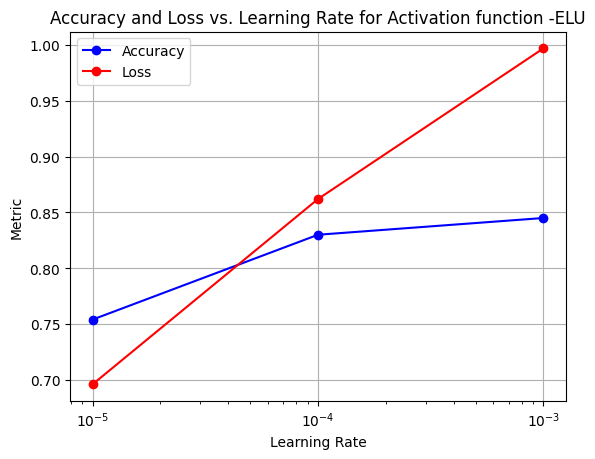

In [28]:
lr = [0.001,0.0001,0.00001]
accuracy = [0.845,0.83,0.754]
loss = [0.997,0.862,0.696]
plt.plot(lr, accuracy, marker='o', color='blue', label='Accuracy')

# Loss plot
plt.plot(lr, loss, marker='o', color='red', label='Loss')

# Set labels and title
plt.title('Accuracy and Loss vs. Learning Rate for Activation function -ELU')
plt.xlabel('Learning Rate')
plt.ylabel('Metric')
plt.xscale('log')  # Set x-axis to log scale for better visualization of learning rates
plt.grid(True)
plt.legend()

# Show plot
plt.show()

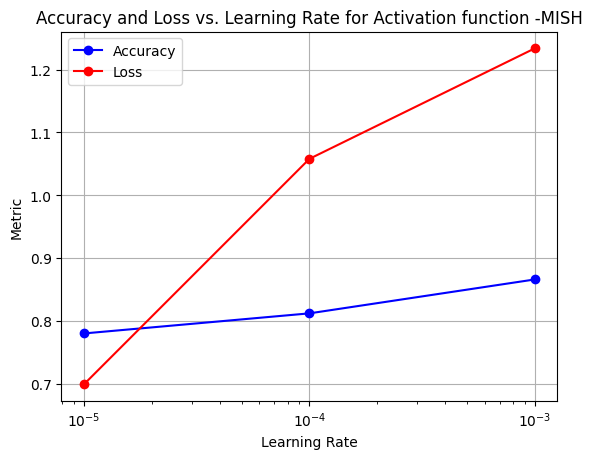

In [29]:
lr = [0.001,0.0001,0.00001]
accuracy = [0.866,0.812,0.78]
loss = [1.234,1.058,0.699]
plt.plot(lr, accuracy, marker='o', color='blue', label='Accuracy')

# Loss plot
plt.plot(lr, loss, marker='o', color='red', label='Loss')

# Set labels and title
plt.title('Accuracy and Loss vs. Learning Rate for Activation function -MISH')
plt.xlabel('Learning Rate')
plt.ylabel('Metric')
plt.xscale('log')  # Set x-axis to log scale for better visualization of learning rates
plt.grid(True)
plt.legend()

# Show plot
plt.show()

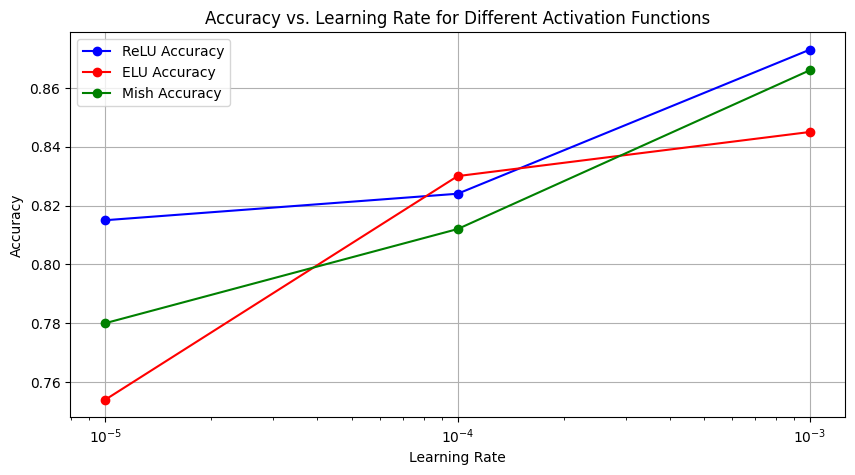

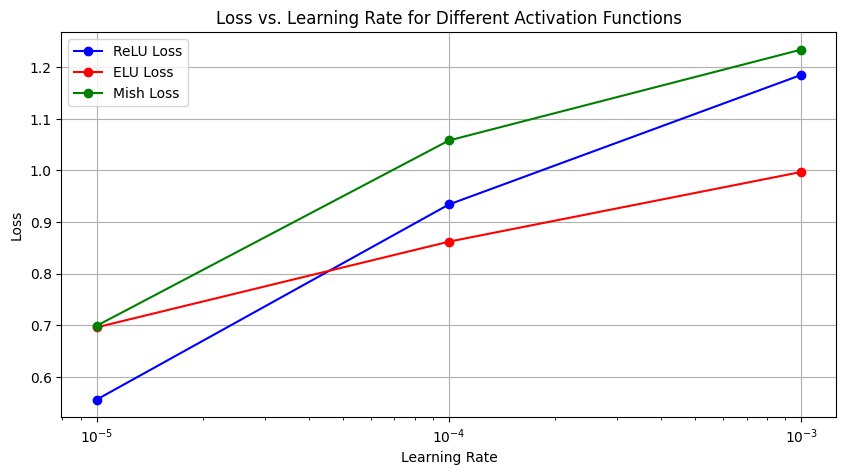

In [30]:
lr = [0.001, 0.0001, 0.00001]
accuracy_relu = [0.873, 0.824, 0.815]
loss_relu = [1.185, 0.934, 0.556]
accuracy_elu = [0.845, 0.83, 0.754]
loss_elu = [0.997, 0.862, 0.696]
accuracy_mish = [0.866, 0.812, 0.78]
loss_mish = [1.234, 1.058, 0.699]

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(lr, accuracy_relu, marker='o', color='blue', label='ReLU Accuracy')
plt.plot(lr, accuracy_elu, marker='o', color='red', label='ELU Accuracy')
plt.plot(lr, accuracy_mish, marker='o', color='green', label='Mish Accuracy')

# Set labels and title
plt.title('Accuracy vs. Learning Rate for Different Activation Functions')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale('log')  # Set x-axis to log scale for better visualization of learning rates
plt.grid(True)
plt.legend()

# Show plot
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(lr, loss_relu, marker='o', color='blue', label='ReLU Loss')
plt.plot(lr, loss_elu, marker='o', color='red', label='ELU Loss')
plt.plot(lr, loss_mish, marker='o', color='green', label='Mish Loss')

# Set labels and title
plt.title('Loss vs. Learning Rate for Different Activation Functions')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')  # Set x-axis to log scale for better visualization of learning rates
plt.grid(True)
plt.legend()

# Show plot
plt.show()

In [31]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", round(score[0], 3))
print("Test accuracy:", round(score[1], 3))
print(score)

Test loss: 0.605
Test accuracy: 0.796
[0.6048957705497742, 0.7962499856948853]


In [32]:
"""
    The functions uses displays the confusion matrix
"""

# ------------------------------------------------- ---------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):
    """
    displays the confusion matrix belongs to the axis between

    args:
        ax (plt): ax used to display the matrix
        cm (numpy): confusion matrix
        classes (list): list of classes
        cmap (plt): matrix color
        title (str): matrix title
        normalize (boolean): true displays cm normalized

    Returns:
        plt: the ax that will be displayed
    """
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax


# ------------------------------------------------- ---------------------
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):
    """
        display normalized and non-normalized cm

    args:
        cm (numpy): confusion matrix
        classes (list): list of classes
        fig_size(_type_):_description_
        cmap (plt, optional): flow of the matrix. Defaults to plt.cm.Blues.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )

In [33]:
# Making prediction
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


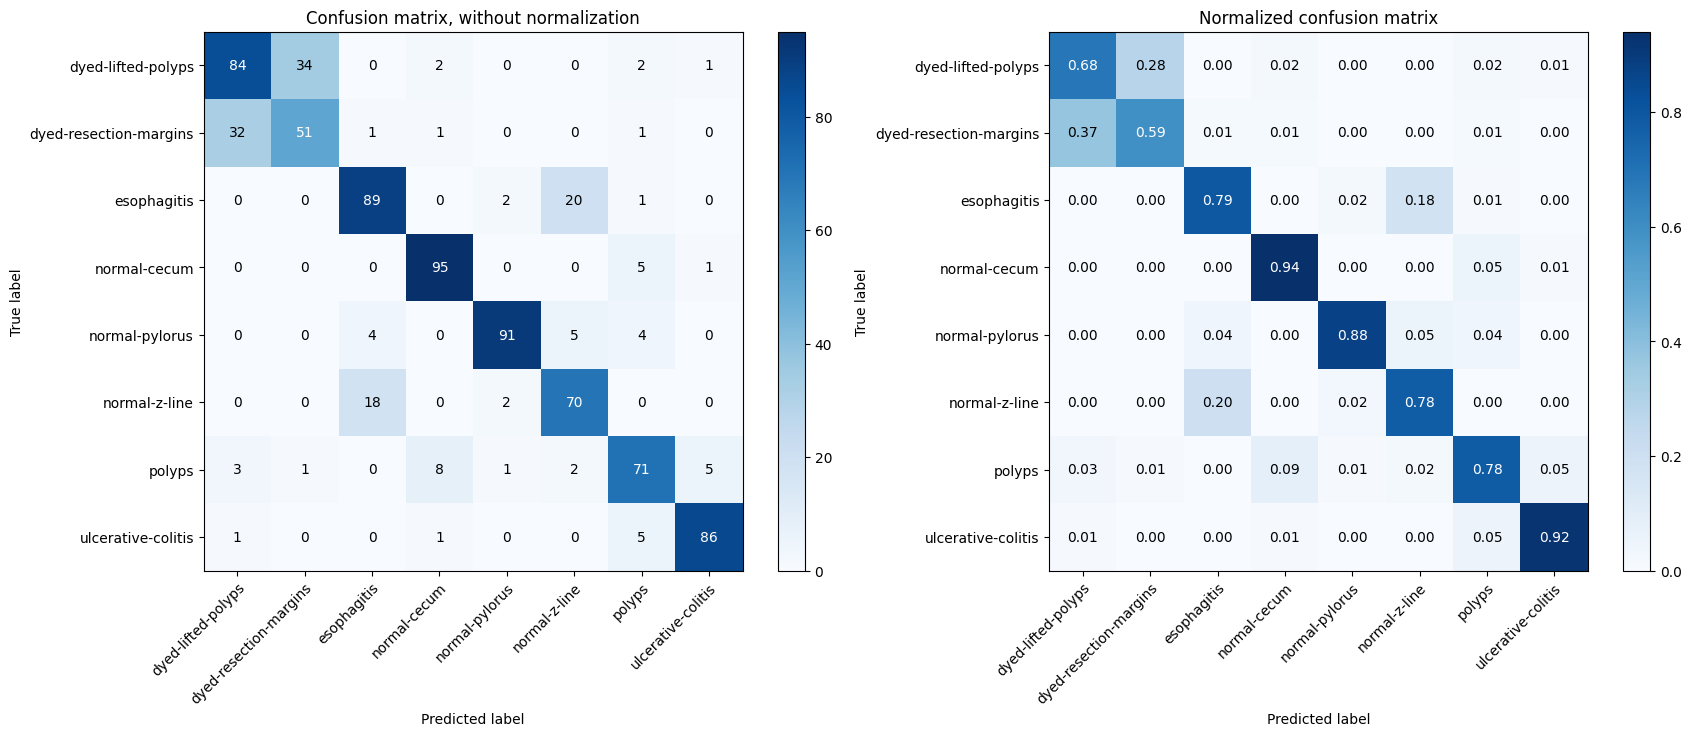

In [34]:
# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))

In [35]:
from sklearn.metrics import classification_report

# assume y_true and y_pred are the ground truth and predicted labels, respectively
# and that they are in the same order
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       123
           1       0.59      0.59      0.59        86
           2       0.79      0.79      0.79       112
           3       0.89      0.94      0.91       101
           4       0.95      0.88      0.91       104
           5       0.72      0.78      0.75        90
           6       0.80      0.78      0.79        91
           7       0.92      0.92      0.92        93

    accuracy                           0.80       800
   macro avg       0.80      0.80      0.80       800
weighted avg       0.80      0.80      0.80       800



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


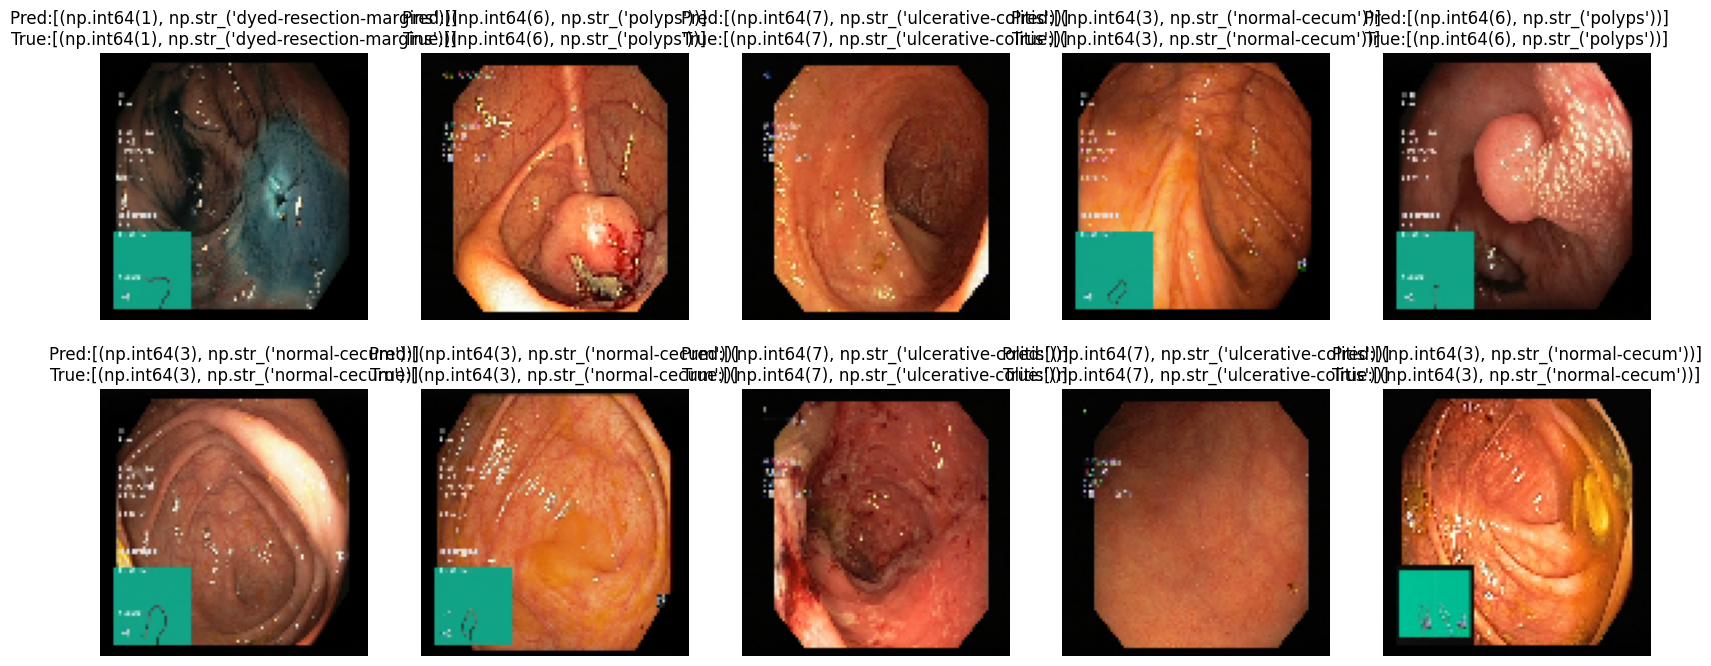

In [37]:
def predict_categorie_img(img, model, categories):
    """
        predict the class of a given image

    args:
        img (numpay): the given image
        model (_type_): the model used for the prediction
        categories (list): list of classes

    Raises:
        TypeError: error if the image is not in RGB (image_dim < 3)

    Returns:
        int: the index of the predie class
        str: the predie class
    """
    try:
        img = img[None,:,:,:]
    except:
        raise TypeError("test image dimension!= 3")
    predict = model.predict(img)
    idx_cat = np.argmax(predict, axis=1)[0]
    return idx_cat, categories[idx_cat]

plt. figure(figsize=(20, 8))
for i in range(10):
    idx = np.random.randint(len(y))
    img = X[idx]
    pred_class = predict_categorie_img(img, model, categories)
    true_class = y[idx], categories[y[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img[:,:,::-1])
    plt.title(f"Pred:[{pred_class}]\nTrue:[{true_class}]")
    plt.axis("off")
plt.show()